In [ ]:
pip install transformers

## Importing Libraries


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, TFViTForImageClassification
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive



## Data Fetch

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/fer2013


## Feature Engineering

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_dir = "/kaggle/input/fer2013/"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("Train folder contents:", os.listdir(train_dir))
print("Test folder contents:", os.listdir(test_dir))

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Class names (should be emotions now)
class_names = train_dataset.classes
print(f"Emotion classes: {class_names}")
print(f"Train images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")

Using device: cuda
Train folder contents: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
Test folder contents: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train images: 28709
Test images: 7178


In [ ]:
labels=[label for _, label in train_dataset]
Counter(labels)

Counter({0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4965, 5: 4830, 6: 3171})

In [ ]:
class_names=train_dataset.classes
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
class_counts = {class_names[i]: count for i, count in Counter(labels).items()}
print(class_counts)

{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


## Data Visualisation

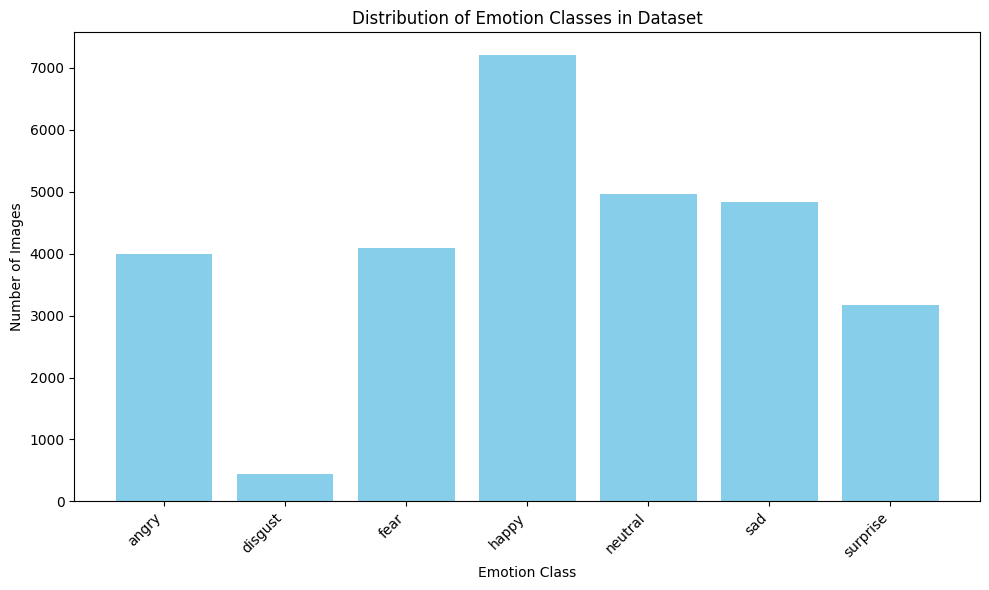

In [ ]:
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Emotion Classes in Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout to prevent overlapping labels
plt.show()

In [ ]:
print(os.listdir(train_dir))

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


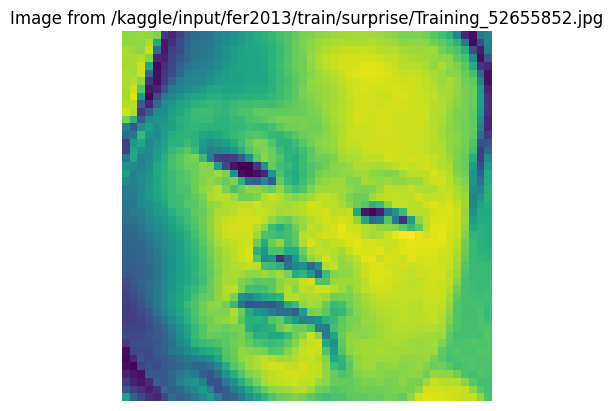

In [ ]:


train_dir = "/kaggle/input/fer2013/train"  # Adjust if needed

# Find all image files in subdirectories
image_files = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

# Check if any images were found
if image_files:
    # Open and display the first image
    image_path = image_files[10]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image from {image_path}")
    plt.show()
else:
    print("No image files found in the directory or subdirectories.")

Found 28709 files belonging to 7 classes.


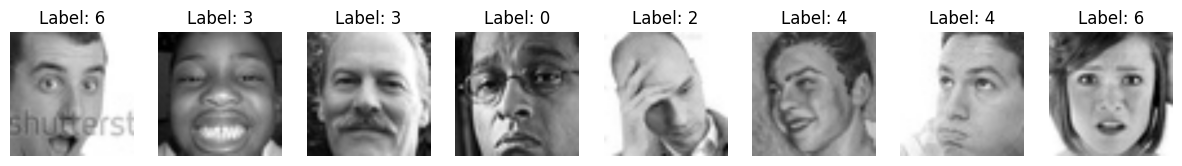

In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/fer2013/train",
    image_size=(224, 224),
    batch_size=8
)

for images, labels in raw_train_ds.take(1):
    num_images = images.shape[0]
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


## Data Preperation and Model Training

In [ ]:

train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"
image_size = (224, 224)
batch_size = None

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=42
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


In [ ]:
MEAN = tf.constant([0.5, 0.5, 0.5])
STD = tf.constant([0.5, 0.5, 0.5])

In [ ]:
single_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    label_mode="int",
    shuffle=True,
    batch_size=1
).map(preprocess_image)

for image, label in single_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())


Found 28709 files belonging to 7 classes.
Image shape: (1, 3, 224, 224)
Label: [5]


In [ ]:
# from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
processor.save_pretrained("/content/drive/MyDrive/models/vit-head-only")



def preprocess_image(image, label):
    image = tf.image.rgb_to_grayscale(image)          # FER2013 is grayscale
    image = tf.image.grayscale_to_rgb(image)          # Convert to RGB 3-channel
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0         # Normalize to [0, 1]
    image = (image - 0.5) / 0.5                        # Normalize to [-1, 1]
    image = tf.transpose(image, [2, 0, 1])             # ✅ Channels-first
    return image, label


# def preprocess_image(image, label):
#     def _preprocess(img, lbl):
#         img = tf.image.convert_image_dtype(img, dtype=tf.uint8)
#         processed = processor(images=img.numpy(), return_tensors="tf")["pixel_values"]
#         pixel_values = tf.squeeze(processed, axis=0)  # shape: [3, 224, 224]
#         label_scalar = tf.convert_to_tensor(lbl.numpy().squeeze(), dtype=tf.int32)
#         return pixel_values, label_scalar

#     pixel_values, label = tf.py_function(
#         func=_preprocess,
#         inp=[image, label],
#         Tout=[tf.float32, tf.int32]
#     )

#     pixel_values.set_shape([3, 224, 224])
#     label.set_shape([])  # Scalar shape
#     return pixel_values, label


# def preprocess_image(image, label):
#     def _preprocess(img):
#         img = tf.image.convert_image_dtype(img, dtype=tf.uint8)
#         pixel_values = processor(images=img.numpy(), return_tensors="tf")["pixel_values"]  # shape: (1, 3, 224, 224)
#         return pixel_values[0]  # keep [3, 224, 224]

#     image = tf.py_function(_preprocess, [image], tf.float32)
#     image.set_shape([3, 224, 224])  # ViT expects [B, 3, 224, 224]
#     return image, label

# train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# Apply to unbatched data
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



NameError: name 'AutoImageProcessor' is not defined

In [ ]:
for images, labels in train_ds.take(1):
    print("Input shape:", images.shape)  # should be [batch_size, 3, 224, 224]
    print("Label shape:", labels.shape)


Input shape: (32, 3, 224, 224)
Label shape: (32,)


In [ ]:
class_names=train_dataset.classes
print(class_names)

## Freezed full model and then tried checking accuracy

In [ ]:
model = TFViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=7,
    id2label={i: c for i, c in enumerate(class_names)},
    label2id={c: i for i, c in enumerate(class_names)},
    ignore_mismatched_sizes=True
)

# Freeze ViT encoder (train only classifier head)
# for layer in model.vit.layers:
#     layer.trainable = False


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for var in model.vit.trainable_variables:
    var._trainable = False


In [ ]:
CLASS_COUNTS = np.array([3995, 436, 4097, 7215, 4965, 4830, 3171], dtype=np.float32)
CLASS_WEIGHTS = (1.0 / CLASS_COUNTS)
CLASS_WEIGHTS = (CLASS_WEIGHTS / CLASS_WEIGHTS.sum()) * 7
CLASS_WEIGHTS = {i: w for i, w in enumerate(CLASS_WEIGHTS)}

In [ ]:
model.compile(
    optimizer="adam",  # <- pass string instead of object
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=CLASS_WEIGHTS
)


Epoch 1/20


718/718 [==============================] - 419s 567ms/step - loss: 0.6993 - accuracy: 0.4903 - val_loss: 1.3152 - val_accuracy: 0.5292
Epoch 2/20
718/718 [==============================] - 407s 565ms/step - loss: 0.6112 - accuracy: 0.5414 - val_loss: 1.2416 - val_accuracy: 0.5523
Epoch 3/20
718/718 [==============================] - 407s 565ms/step - loss: 0.5819 - accuracy: 0.5569 - val_loss: 1.2106 - val_accuracy: 0.5570
Epoch 4/20
718/718 [==============================] - 407s 564ms/step - loss: 0.5649 - accuracy: 0.5675 - val_loss: 1.2005 - val_accuracy: 0.5616
Epoch 5/20
718/718 [==============================] - 406s 564ms/step - loss: 0.5529 - accuracy: 0.5746 - val_loss: 1.1734 - val_accuracy: 0.5682
Epoch 6/20
718/718 [==============================] - 407s 565ms/step - loss: 0.5433 - accuracy: 0.5820 - val_loss: 1.1759 - val_accuracy: 0.5699
Epoch 7/20
718/718 [==============================] - 406s 564ms/step - loss: 0.5358 - accuracy: 0.5863 - val_loss: 1.1483 - val_accura

KeyboardInterrupt: 

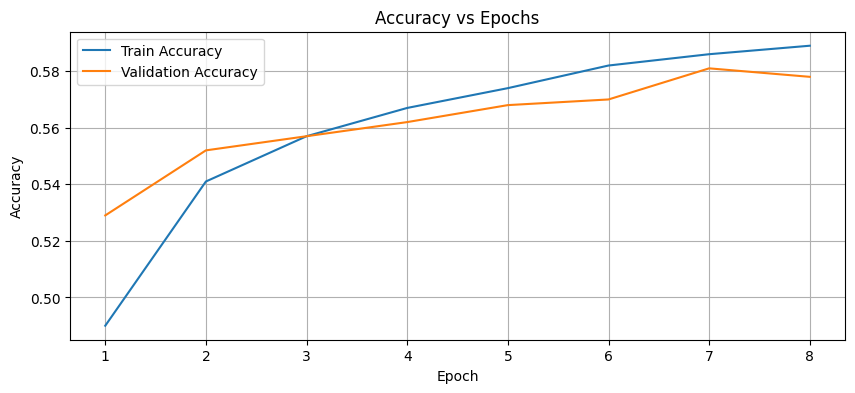

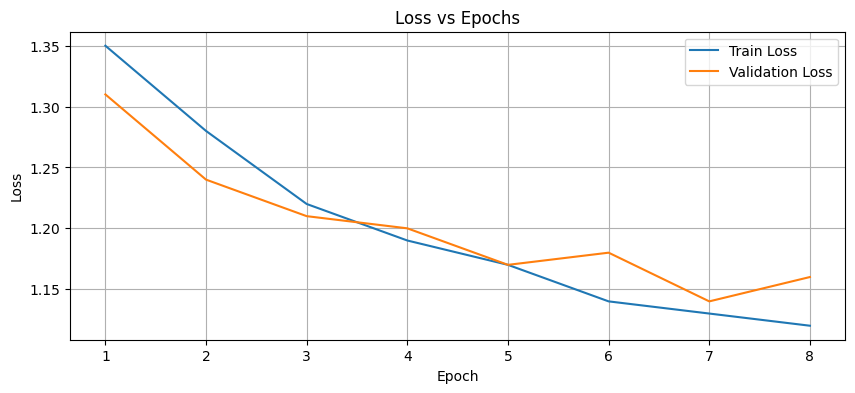

In [ ]:
# Example: Replace these with your actual values from logs
train_acc = [0.49, 0.541, 0.557, 0.567, 0.574, 0.582, 0.586, 0.589]
val_acc   = [0.529, 0.552, 0.557, 0.562, 0.568, 0.570, 0.581, 0.578]
train_loss = [1.35, 1.28, 1.22, 1.19, 1.17, 1.14, 1.13, 1.12]
val_loss   = [1.31, 1.24, 1.21, 1.20, 1.17, 1.18, 1.14, 1.16]

epochs = range(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
model.save("/content/vit_emotion_head",save_format="tf")
# /content/sample_data

In [ ]:
!zip -r /content/vit_emotion_head.zip /content/vit_emotion_head


  adding: content/vit_emotion_head/ (stored 0%)
  adding: content/vit_emotion_head/saved_model.pb (deflated 92%)
  adding: content/vit_emotion_head/fingerprint.pb (stored 0%)
  adding: content/vit_emotion_head/assets/ (stored 0%)
  adding: content/vit_emotion_head/keras_metadata.pb (deflated 95%)
  adding: content/vit_emotion_head/variables/ (stored 0%)
  adding: content/vit_emotion_head/variables/variables.index (deflated 84%)
  adding: content/vit_emotion_head/variables/variables.data-00000-of-00001 (deflated 69%)


## Now again training the model with using head and freezing the rest model

In [ ]:
for var in model.trainable_variables:
    var._trainable = False

# Unfreeze classifier only
for var in model.classifier.trainable_variables:
    var._trainable = True

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8
)


Epoch 1/8


718/718 [==============================] - 415s 563ms/step - loss: 1.3224 - accuracy: 0.5148 - val_loss: 1.1979 - val_accuracy: 0.5550
Epoch 2/8
718/718 [==============================] - 401s 559ms/step - loss: 1.1653 - accuracy: 0.5682 - val_loss: 1.1454 - val_accuracy: 0.5746
Epoch 3/8
718/718 [==============================] - 404s 563ms/step - loss: 1.1210 - accuracy: 0.5858 - val_loss: 1.1201 - val_accuracy: 0.5823
Epoch 4/8
718/718 [==============================] - 401s 559ms/step - loss: 1.0940 - accuracy: 0.5938 - val_loss: 1.1051 - val_accuracy: 0.5896
Epoch 5/8
718/718 [==============================] - 403s 562ms/step - loss: 1.0757 - accuracy: 0.6007 - val_loss: 1.0951 - val_accuracy: 0.5950
Epoch 6/8
718/718 [==============================] - 402s 559ms/step - loss: 1.0615 - accuracy: 0.6064 - val_loss: 1.0908 - val_accuracy: 0.5961
Epoch 7/8
718/718 [==============================] - 402s 560ms/step - loss: 1.0502 - accuracy: 0.6115 - val_loss: 1.0840 - val_accuracy: 0.

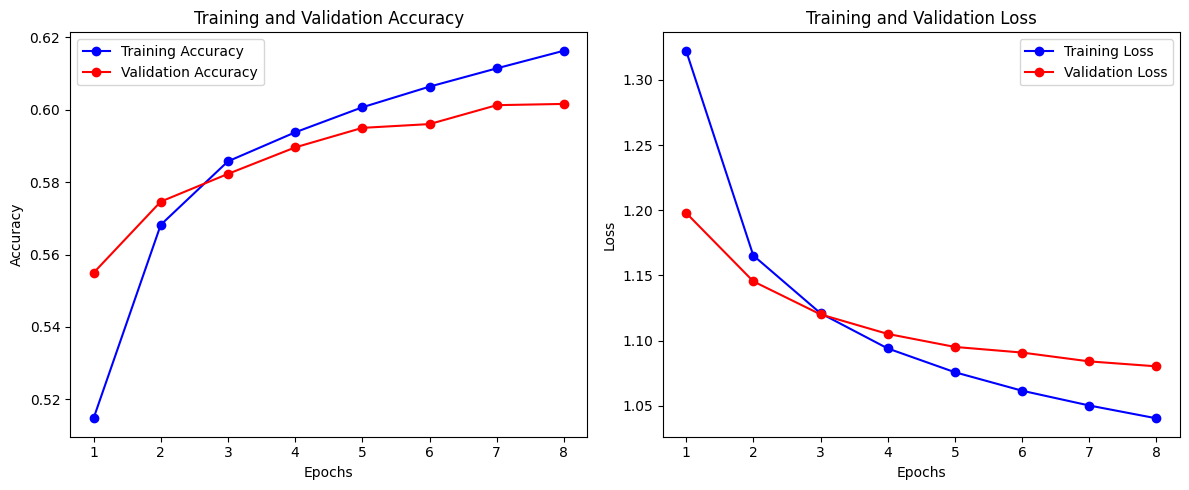

In [ ]:
# Extract values from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.makedirs("/content/drive/MyDrive/models/vit-head-only", exist_ok=True)


In [ ]:
model.save_pretrained("/content/drive/MyDrive/models/vit-head-only")


## Now for improving accuracy trying to freeze some top layersfor better accuracy

In [ ]:
# Load from the location where you saved it
model = TFViTForImageClassification.from_pretrained(
    "/content/drive/MyDrive/models/vit-head-only"
)


All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/vit-head-only.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [ ]:
def freeze_all_layers(model):
    for layer in model.submodules:
        for var in layer.trainable_variables:
            var._trainable = False

def unfreeze_classifier_and_top_n_layers(model, top_n=3):
    total_layers = len(model.vit.encoder.layer)
    for i in range(total_layers - top_n, total_layers):
        for var in model.vit.encoder.layer[i].trainable_variables:
            var._trainable = True


In [ ]:
from transformers import TFViTForImageClassification

model = TFViTForImageClassification.from_pretrained(
    "/content/drive/MyDrive/models/vit-head-only",
    num_labels=7
)

freeze_all_layers(model)

unfreeze_classifier_and_top_n_layers(model, top_n=3)

print("Trainable variable count:", len(model.trainable_variables))
for var in model.trainable_variables:
    print(var.name)



All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/vit-head-only.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Trainable variable count: 200
tf_vi_t_for_image_classification_8/vit/embeddings/cls_token:0
tf_vi_t_for_image_classification_8/vit/embeddings/position_embeddings:0
tf_vi_t_for_image_classification_8/vit/embeddings/patch_embeddings/projection/kernel:0
tf_vi_t_for_image_classification_8/vit/embeddings/patch_embeddings/projection/bias:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/attention/query/kernel:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/attention/query/bias:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/attention/key/kernel:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/attention/key/bias:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/attention/value/kernel:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/attention/value/bias:0
tf_vi_t_for_image_classification_8/vit/encoder/layer_._0/attention/output/dense/kernel:0
tf_vi_t_for_image_classification_

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3


718/718 [==============================] - 575s 761ms/step - loss: 1.0714 - accuracy: 0.6024 - val_loss: 0.9938 - val_accuracy: 0.6250
Epoch 2/3
718/718 [==============================] - 542s 755ms/step - loss: 0.9136 - accuracy: 0.6590 - val_loss: 0.9842 - val_accuracy: 0.6319
Epoch 3/3
718/718 [==============================] - 541s 754ms/step - loss: 0.8268 - accuracy: 0.6938 - val_loss: 0.9815 - val_accuracy: 0.6387


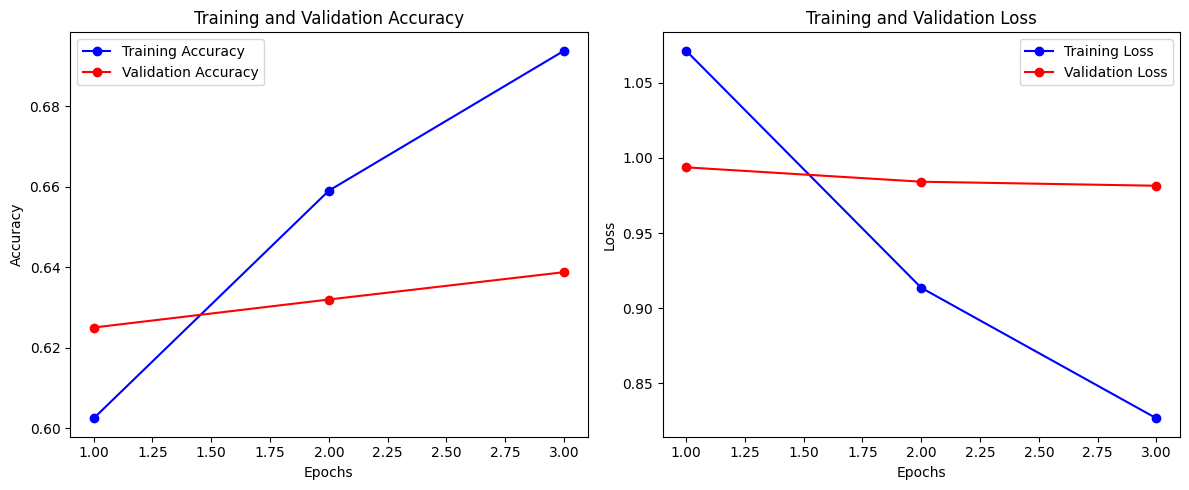

In [ ]:
import matplotlib.pyplot as plt

# Extract values from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save_pretrained("/content/drive/MyDrive/models/vit-unfreeze-top3")


## Model Testing

In [ ]:
from transformers import TFViTForImageClassification, AutoImageProcessor

# Load processor and model from your saved directory
from transformers import AutoImageProcessor, TFViTForImageClassification
# from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFViTForImageClassification.from_pretrained("/content/drive/MyDrive/models/vit-unfreeze-top3")


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/vit-unfreeze-top3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [ ]:
processor.save_pretrained("/content/drive/MyDrive/models/vit-finetuned-3layers")


['/content/drive/MyDrive/models/vit-finetuned-3layers/preprocessor_config.json']

In [ ]:
processor = AutoImageProcessor.from_pretrained("/content/drive/MyDrive/models/vit-finetuned-3layers")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
!pip install -q tensorflow


In [ ]:
from PIL import Image
import tensorflow as tf
import numpy as np
import os

# Load a sample image from your test folder
image_path = "/content/WhatsApp Image 2025-04-15 at 11.20.28 PM (1).jpeg"  # Change this to your actual image path
image = Image.open(image_path).convert("RGB")  # Ensure 3 channels

# Preprocess the image
inputs = processor(images=image, return_tensors="tf")


In [ ]:
import tensorflow as tf

# Run the image through the model
outputs = model(**inputs)
logits = outputs.logits

# Convert logits to probabilities
probabilities = tf.nn.softmax(logits, axis=-1)

# Get top 3 predictions
top_3_indices = tf.argsort(probabilities, direction='DESCENDING')[0][:3]
top_3_probs = tf.gather(probabilities[0], top_3_indices)

# Get class labels
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
top_3_labels = [class_names[i] for i in top_3_indices.numpy()]

# Print top 3 predictions
print("Top 3 Predicted Emotions:")
for i in range(3):
    print(f"{top_3_labels[i]}: {top_3_probs[i].numpy()*100:.2f}%")


Top 3 Predicted Emotions:
happy: 98.25%
neutral: 0.67%
sad: 0.42%


## Model Results (Classification Report)

In [ ]:
# Initialize lists
y_true = []
y_pred = []

# Loop over test dataset
for batch in test_ds:  # already batched
    images, labels = batch
    outputs = model(images, training=False)
    logits = outputs.logits
    predictions = tf.argmax(logits, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predictions.numpy())


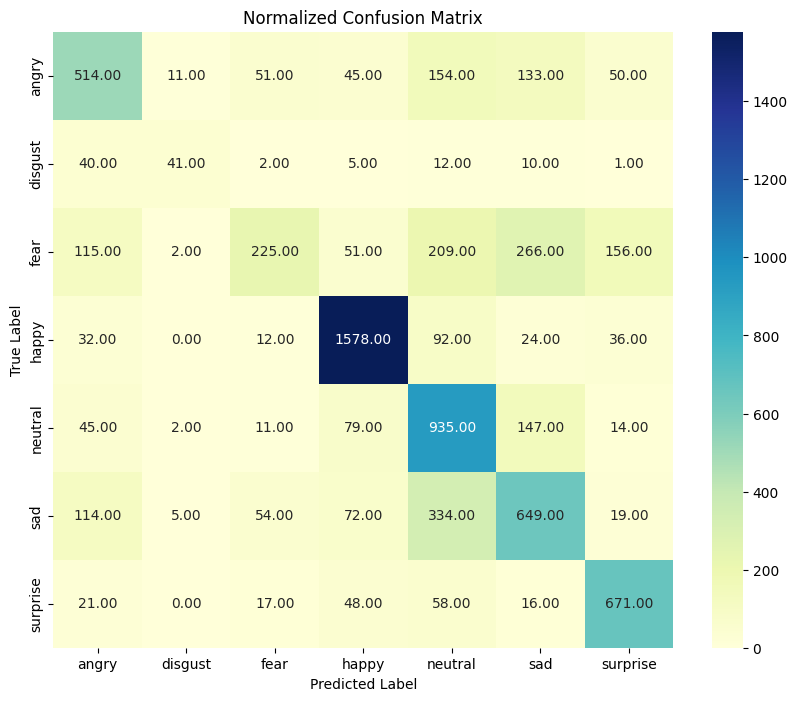

In [ ]:
# Define class names
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

       angry       0.58      0.54      0.56       958
     disgust       0.67      0.37      0.48       111
        fear       0.60      0.22      0.32      1024
       happy       0.84      0.89      0.86      1774
     neutral       0.52      0.76      0.62      1233
         sad       0.52      0.52      0.52      1247
    surprise       0.71      0.81      0.75       831

    accuracy                           0.64      7178
   macro avg       0.64      0.59      0.59      7178
weighted avg       0.64      0.64      0.63      7178

